In [58]:
import os
from scipy.io import loadmat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
import mne
import funcs4eeg as fe
import re
import imp
import ast
imp.reload(fe)

<module 'funcs4eeg' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\eeg_analysis\\funcs4eeg.py'>

In [59]:
real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]
bands = [[8, 12], [12.5, 30], [30, 80]]
band_names = ['alpha', 'beta', 'gamma']

band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase', 'real before', 'real after', 'real increase'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]

In [60]:
case='(5 | 6) & 8'
watch='1 fixation'
tmin = 0
tmax = 2

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append(power_after - power_before)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append(power_after - power_before)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase'] = str(sham_increase)


In [61]:
display(band_power)

,band name,f low,f high,sham before,sham after,sham increase,real before,real after,real increase
0,alpha,8.0,12,"[1.0239165246441671e-08, 1.0075281627975443e-0...","[1.607969819381952e-08, 8.954806185050397e-08,...","[5.840532947377849e-09, -1.1204754429250458e-0...","[1.9374987999587885e-08, 5.6327854487872766e-0...","[2.5171402933984267e-08, 5.1943687081437104e-0...","[5.796414934396383e-09, -4.384167406435662e-09..."
1,beta,12.5,30,"[2.2037218564938948e-08, 2.9212839051013634e-0...","[1.936662751029833e-08, 1.9178220646229274e-08...","[-2.6705910546406196e-09, -1.003461840478436e-...","[2.1810634067701926e-08, 2.376666810911102e-08...","[1.6021743285402633e-08, 2.2595227009915802e-0...","[-5.7888907822992925e-09, -1.1714410991952171e..."
2,gamma,30.0,80,"[2.8937626073851377e-08, 1.1234960918170658e-0...","[2.205454723702338e-08, 1.059974384782273e-08,...","[-6.883078836827998e-09, -6.352170703479277e-1...","[2.5335202422718982e-08, 2.9641710772837257e-0...","[1.1979429134336062e-08, 1.186078060151661e-08...","[-1.335577328838292e-08, -1.778093017132065e-0..."


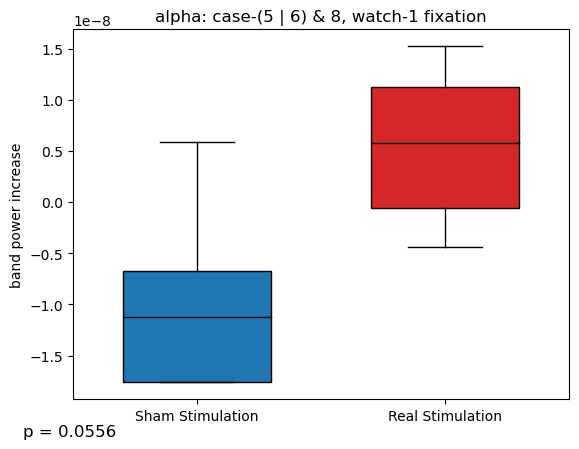

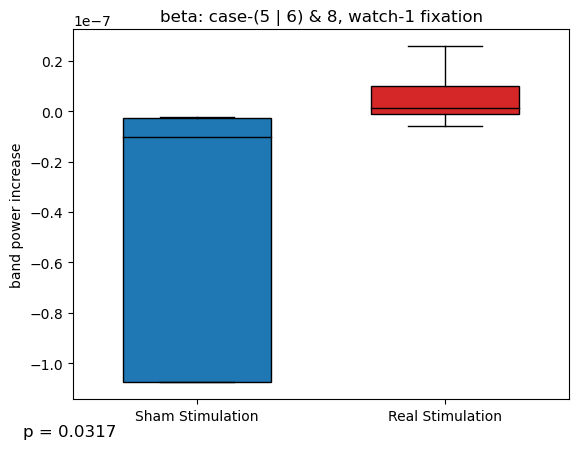

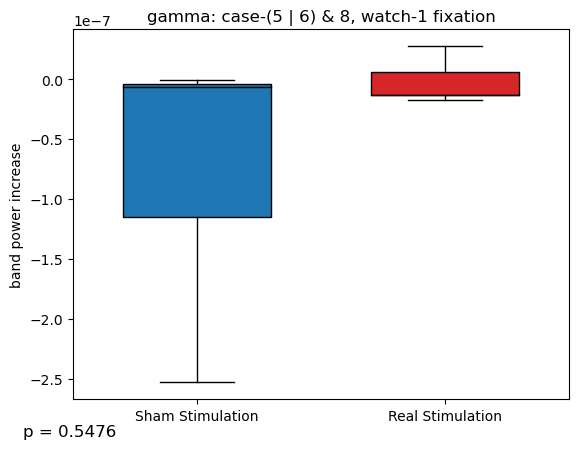

In [62]:
compare_objects = ['alpha', 'beta', 'gamma']
for compare_object in compare_objects:
    save_path = os.path.join('..', '..', '..', 'docs', 'report', 'figs', case+"_"+watch+"_"+compare_object+'.png')

    diff_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase'].apply(ast.literal_eval).values[0])
    diff_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase'].apply(ast.literal_eval).values[0])
    
    # create boxplot
    # Create a box plot with whiskers
    fig, ax = plt.subplots()
    boxplots = ax.boxplot([diff_sham, diff_real], patch_artist=True, widths=0.6, showfliers=False)

    # Set colors for the box plots
    colors = ['#1f77b4', '#d62728']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)

    # Set median line color to black
    for median in boxplots['medians']:
        median.set_color('black')

    plt.xticks([1, 2], ['Sham Stimulation', 'Real Stimulation'])
    plt.ylabel('band power increase')
    plt.title(compare_object+": case-"+case+", watch-"+watch)

    # Perform the Mann-Whitney U test
    U, p_value = stats.mannwhitneyu(diff_sham, diff_real)

    # Add the p-value to the plot
    ax.annotate(f'p = {p_value:.4f}',
                xy=(-0.1, -0.1),
                xycoords=('axes fraction', 'axes fraction'),
                ha='left', fontsize=12)
    # plt.savefig(save_path, format='png')

    plt.show()